# 1. Implement LapGMM and apply it to the two-moon case

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp

plt.rcParams["figure.figsize"] = (8,5)

- First let's figure out what 'two moon' look like

It's beautiful.


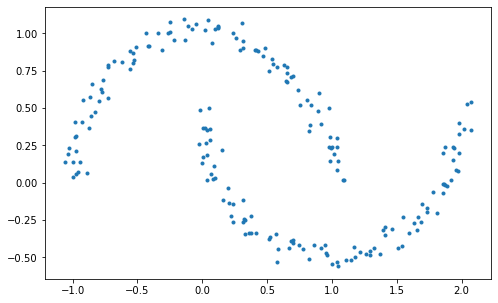

In [3]:
## Generate Data
from sklearn.datasets import make_moons

# Make two moons
moons_pos, moons_label = make_moons(n_samples=200, noise=0.05, shuffle=False, random_state=0)

# Plot two moons
plt.plot(moons_pos[:,0],moons_pos[:,1],'.')
print("It's beautiful.")

## 1.1 LapGMM implementation

In [36]:
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from sklearn.neighbors import kneighbors_graph


class LapGMM:
    
    def __init__(self, data, K=2, p=8, lmd=1e3, tol=1e-6, weight_matrix='D-P',inner_max_iter = 200,outer_max_iter = 2000 , dismiss_E = True):
        '''
        Initilize the hyperparameter,
        Construct a nearest neighbor graph with weight matrix S,
        Initialize the parameters Theta_0 by using K-means algorithm.
        
        Input: 
        data: mxn np.array, m is the number of points, n is the dimension
        K: the number of clusters
        p: the number of nearest neighbors
        lmd: regularization parameter
        tol: the termination condition value
        '''
        
        # Initilize the hyperparameter
        self.random_seed = 0
        self.data = np.array(data)
        self.m, self.n = data.shape
        self.K = K
        self.p = p
        self.lmd = lmd
        self.tol = tol
        self.gamma = 0.9 # Set the initial value γ = 0.9
        self.weight_matrix = weight_matrix
        
        self.inner_max_iter = inner_max_iter
        self.outer_max_iter = outer_max_iter
        self.count = 1
        
        self.dismiss_E = dismiss_E
        
        # Construct a nearest neighbor graph
        self._Construct_S()
        
        # Initialize the parameters Theta_0 and posterior probability by using K-means algorithm
        self._Init_Theta0()

        # Initialize the regularized log likelihood
        self.reg_loglikelihood = self._Eval_Regularized_LL(self.posterior_prob, self.alpha, self.mu, self.sigma,self.data)
        
    def _Construct_S(self):
        '''
        Construct a nearest neighbor graph with weight matrix S
        '''
                
        idx = kneighbors_graph(self.data, n_neighbors=self.p).toarray()
        
        # Initialize the weight matrix to zero
        self.S = np.zeros((self.m, self.m))
        
        for i in range(self.m):
            for j in range(self.m):
                
                if idx[i][j]==1:
                    
                    if self.weight_matrix=='0-1':
                        self.S[i,j]=1
                    elif self.weight_matrix.upper()=='H-K':
                        t = 2 # Note: this can be adjusted 
                        self.S[i,j] = np.exp(- np.linalg.norm(self.data[i,:] - self.data[j,:])/ t)
                    elif self.weight_matrix.upper()=='D-P':
                        self.S[i,j] = np.dot(self.data[i,:],self.data[j,:])
                    else : 
                        raise ValueError('Please enter the correct definition of weight matrix.')
                        
                    self.S[j,i]=self.S[i,j] # note it is an undirected graph

        # construct L
        D = np.diag(np.sum(self.S, axis = 1))
        self.L = D-self.S
    
    def _Init_Theta0(self):
        # Use K-means as a warm start
        kmeans = KMeans(n_clusters=self.K, random_state=self.random_seed).fit(self.data)
        
        self.alpha = np.array([ np.sum(kmeans.labels_==i)/self.m for i in range(self.K)])

        self.mu = kmeans.cluster_centers_
        self.sigma = [np.cov(self.data[kmeans.labels_==i], rowvar=False) for i in range(self.K)]
        
        self.posterior_prob = self._E_step()
        
        
    def run(self):
        
        while self.count < self.outer_max_iter:
            self.gamma = 0.9 # Reset the size of step
            
            self._E_step() # Run the E step.
            
            inner_loop = 1
            while True:
                
                posterior_prob_update, alpha_update, mu_update, sigma_update = self._M_step(self.posterior_prob,self.gamma) # Run M step
                
                reg_log_likeli_n = self._Eval_Regularized_LL(posterior_prob_update, alpha_update, mu_update, sigma_update,self.data) # Evaluate the updated regularized log likelihood after M step
                
                reg_log_likeli_increment = reg_log_likeli_n - self.reg_loglikelihood # Calculate the LL increment
                if reg_log_likeli_increment > 0:
                    break
                    
                if inner_loop == self.inner_max_iter:
                    print("\nM-step didn't converge, it hit the maximum number of iterations")
                    print('Now regularized log likelihood is = ',reg_log_likeli_n)
                    break
                self.gamma *= 0.9
                inner_loop += 1
                
            # Successfully Run M step, i.e. LL increases after this iteration
            # Update the parameters
            self.alpha = alpha_update
            self.mu = mu_update
            self.sigma = sigma_update
            self.posterior_prob = posterior_prob_update
            self.reg_loglikelihood = reg_log_likeli_n
            
            # print('# inner_iterations = ',inner_loop)
            # print('Get out M-step, now reg_ll = ', reg_log_likeli_n)
            
            if reg_log_likeli_increment > 0 and reg_log_likeli_increment < self.tol:
                break
            self.count += 1
            
            if self.count % 200 == 0:
                print('\niteration #{}, reg_ll = {}'.format(self.count,reg_log_likeli_n))

        if self.count >= self.outer_max_iter:
            print("\nThe regularized log likelihood didn't converge, it hit the maximum number of iterations.\n")
    
    def _E_step(self):
        
        # Calculate p(x_i | theta_k)
        normal_prob = np.zeros((self.m, self.K))
        for k in range(self.K):
            # For each component
            normal_prob[:,k] = multivariate_normal.pdf(self.data, mean=self.mu[k,:],cov=self.sigma[k])
            
        # Calculate the updated posterior probability
        numerator = self.alpha * normal_prob
        denominator = np.sum(numerator, axis = 1, keepdims=True)
        
        if not self.dismiss_E:
            self.posterior_prob = numerator / denominator
        return numerator / denominator
        
    def _M_step(self, posterior_prob, gamma):
        
        # Calculate posterior_prob_update
        second_term_numerator = np.dot(self.S, posterior_prob)
        second_term_denominator = np.sum(self.S, axis = 1, keepdims=True)
        second_term = second_term_numerator / second_term_denominator
        
        posterior_prob_update = (1-gamma)*posterior_prob + gamma*second_term
        
        # Calculate alpha_update
        alpha_update = np.sum(posterior_prob_update, axis=0, keepdims=False) / self.m
        
        # Calculate mu_update
        mu_numerator = np.dot(posterior_prob_update.T, self.data)
        mu_denominator = np.sum(posterior_prob_update, axis=0, keepdims=True).T
        mu_update = mu_numerator / mu_denominator
        
        # Calculate sigma_update
        sigma_update = []
        for k in range(self.K):
            
            sigma_tmp = np.zeros((self.n,self.n))
            for j in range(self.m):                
                sigma_tmp = sigma_tmp + np.dot( (self.data[j,:]-mu_update[k,:]).reshape(-1,1),\
                                    (self.data[j,:]-mu_update[k,:]).reshape(1,-1) ) * \
                posterior_prob_update[j,k]
                
            sigma_tmp = sigma_tmp / np.sum(posterior_prob_update[:,k])
            
            sigma_update.append(sigma_tmp)

        return posterior_prob_update, alpha_update, mu_update, sigma_update
    
    def _Eval_Regularized_LL(self, posterior_prob, alpha, mu, sigma, data, verbose = False):
        # Calculate p(x_i | theta_k)
        normal_prob = np.zeros((self.m, self.K))
        
        for k in range(self.K):
            # For each component
            normal_prob[:,k] = multivariate_normal.pdf(self.data, mean=mu[k,:],cov=sigma[k])
        
        log_likelihood = np.log(np.dot(normal_prob, alpha.reshape(-1,1)))
        log_likelihood = np.sum(log_likelihood)
        
        R = 0.0 # Sum of R_i
        
        for k in range(self.K):
            
            R += np.squeeze(np.dot(np.dot(posterior_prob[:,k].reshape(1,-1),self.L), \
                                             posterior_prob[:,k].reshape(-1,1)) )
        if verbose:
            print('log_likelihood = ', log_likelihood)
            print('R = ', R)
            print('regularized_ll = ', log_likelihood - self.lmd * R)
        return log_likelihood - self.lmd * R
    
    def GetLabel(self):
        return np.argmax(self.posterior_prob, axis=1)

## 1.2 Experiment

### 1.2.1 Dismiss E-step

In [37]:
# Fit the data
lapgmm = LapGMM(moons_pos)
lapgmm.run()


iteration #200, reg_ll = -498.07849256386316

iteration #400, reg_ll = -403.2419136467686

iteration #600, reg_ll = -377.83836423612576

iteration #800, reg_ll = -370.72690772327707

iteration #1000, reg_ll = -368.7553682654479

iteration #1200, reg_ll = -368.2259064969941

iteration #1400, reg_ll = -368.09540814338646

iteration #1600, reg_ll = -368.07078645901544


In [31]:
print('Number of iterations of outer loop: ', lapgmm.count)

Number of iterations of outer loop:  1673


In [32]:
# Get predicted labels
labels = lapgmm.GetLabel()

Text(0.5, 1.0, 'LapGMM Clustering (dismissing E-step)')

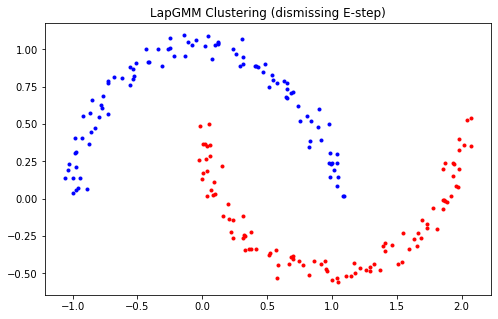

In [33]:
plt.plot(moons_pos[labels==1,0],moons_pos[labels==1,1],'b.')
plt.plot(moons_pos[labels==0,0],moons_pos[labels==0,1],'r.')
plt.title('LapGMM Clustering (dismissing E-step)')

### 1.2.2 Include E-step

In [25]:
# Fit the data
lapgmm2 = LapGMM(moons_pos,dismiss_E=False)
lapgmm2.run()


M-step didn't converge, it hit the maximum number of iterations
Now regularized log likelihood is =  -5822.932738368058

M-step didn't converge, it hit the maximum number of iterations
Now regularized log likelihood is =  -6516.373341822862

M-step didn't converge, it hit the maximum number of iterations
Now regularized log likelihood is =  -6565.005518416804

M-step didn't converge, it hit the maximum number of iterations
Now regularized log likelihood is =  -6565.324112521478


In [26]:
print('# Number of iterations of outer loop: ', lapgmm2.count)

# Number of iterations of outer loop:  125


In [27]:
# Get predicted labels
labels2 = lapgmm2.GetLabel()

Text(0.5, 1.0, 'LapGMM Clustering (incuding E-step)')

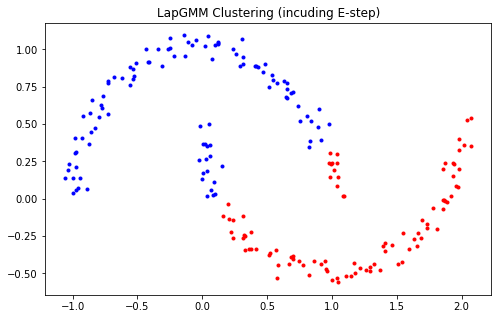

In [29]:
plt.plot(moons_pos[labels2==1,0],moons_pos[labels2==1,1],'b.')
plt.plot(moons_pos[labels2==0,0],moons_pos[labels2==0,1],'r.')
plt.title('LapGMM Clustering (incuding E-step)')

In [38]:
print('Print the structure of regularized log likelihood')
lapgmm._Eval_Regularized_LL(lapgmm.posterior_prob,lapgmm.alpha,\
                            lapgmm.mu,lapgmm.sigma,lapgmm.data,verbose=True)

Print the structure of regularized log likelihood
log_likelihood =  -368.04908343207705
R =  2.068927068624021e-05
regularized_ll =  -368.0697727027633


-368.0697727027633

## 1.1 Implementation Details

- Hyperparamter choice:

the number of clusters: K = 2;

the number of nearest neighbors: p = 8;

regularization parameter: $\lambda$ = 1e3;

the termination condition value: $\delta$ = 1e-6

weight_matrix: use Dot-product weighting.

maximum iteration of the inner loop (the loop in M-step) : 200

maximum iteration of the inner loop (the loop on EM step alternation): 2000

- E-step dismiss

In our implementaion, when it comes to E step update, it returns Null, i.e. it does nothing.
> When E-step update is activated, many EM alternations have endless inner loop, in which the algorithm hits the maximum iteration number and breaks out of the loop, even the regularized log likelihood is not increased at all. And eventally, the algorithm does not give the expected clustering.

> This happens regardless of our random seed choice and fine hyperparameter tuning. It is the flaw rooted in this algorithm. We will show how it fails in the Result Analysis Section.

# 2. Result Analysis

## 2.1 What happens on E-step

- First, we run the algorithm without E-step, and it converges successfully, without hitting maximum number of iteration.
- And now the algorithm gives the following final reg_loglikelihood 

In [271]:
final_reg_ll = lapgmm.reg_loglikelihood
print('The algorithm gives reg_loglikelihood = ', final_reg_ll)

The algorithm gives reg_loglikelihood =  -368.0697727027633


- Second, with all estimated parameters obtained with only running M-step, we now run one E-step.

In [34]:
# record the final posterior probability that the algorithm with only M-step gives
post_prob_before_E_step = lapgmm.posterior_prob
# record the posterior probability if we run one E-step further
post_prob_after_E_step = lapgmm._E_step()

In [279]:
# Calculate the regularized log likelihood after one E-step
_, alpha_after_E_step, mu_after_E_step, sigma_after_E_step=lapgmm._M_step(post_prob_after_E_step,gamma=0.0)

reg_ll_after_E_step = lapgmm._Eval_Regularized_LL(post_prob_after_E_step,alpha_after_E_step,\
                            mu_after_E_step,sigma_after_E_step,lapgmm.data,verbose=True)
print('regularized log likelihood after E-step',reg_ll_after_E_step)

log_likelihood =  -359.946267510427
R =  6.268439268826506
regularized_ll =  -6628.385536336933
regularized log likelihood after E-step -6628.385536336933


- Comparison

In [280]:
# Print the Regularized Log Likelihood before and after one E-step running
df = pd.DataFrame([{'Before_E_step':final_reg_ll,'After_E_step':reg_ll_after_E_step}])
df.index = ['Regularized Log Likelihood']
df

,Before_E_step,After_E_step
Regularized Log Likelihood,-368.069773,-6628.385536


- Third, Observation:
> - Note that during the training process without E-step, our objective, regularized log likelihood, continually increases, which indicates a constant improvement on algorithm performance.
> - However, we see that after one E-step, the regularized log likelihood drops dramatically ( -368.069773 to -6628.385536). 

## 2.2 Why the E-step loses all the benefit we get from M-step


>The numeric result shows the drop on regularized log likelihood is due to the big jump up on its smoothness part, $\sum_{i=1}^{K}R_i$, from 2e-5 to 6.27, which leads to a quite rough posterior probabilities and totally goes the other way from the M-step ( Remeber a key objective in M-step is to smooth the posterior probabilities)

- In a typical EM algorithm, the objective is the log likelihood. And when we reset the posterior probability distribution (E-step), it will not decrease, which is also true for M-step. However in this algorithm, the objective is the regularized log likelihood. 

#### Flaw 1:
- E-step and M-step are shooting at different target.
> E-step's target is pure log likelihood, shooting it using KL-divergence / Jensen's inequality.
> M-step's target is regularized log likelihood, shooting it using Newton-Raphson method to smooth the posterior probabilities, and characteristic of normal distribution to maximize the log likelihood.


#### Flaw 2:
- E-step could make the posterior probabilities quite rough and M-step can not make up for that loss.
> We see from the experiment that after obtaining smoothness 2e-5, the E-step running turns it to 6.27. Further experiments suggest the M-step can no longer drag smoothness back to 2e-5, which means the inner loop is endless. This breakdown happens frequently during the training that includes E-step.

#### Conclusion
- The algorithm in this paper is not EM algorithm, at least it doesn't follow the spirit of EM. And this mixture doesn't seem to work well as expected.
- It could be true that M-step is able to make up the loss from E-step on smoothness in some problems or some settings. But we don't see this happen in two-moon case. And we want robustness.
> In general we wouldn't recommend this kind of methodology, coupling different tasks and disabling us from working on them independently. We would want orthogonalization on problems.

- However, the algorithm does offer a chance to cluster data when the boundary is not linear or quadratic, by smoothing the posterior probability. As we can see from the ploting, it discriminates the two moons perfectly.